<a href="https://colab.research.google.com/github/Voland24/ModernComputerVisionPytorch/blob/main/Chapter_4_4_Classifying_real_world_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying real world images

In this notebook, we will build a model used for classification of real world images, dataset gathered from Kaggle of cats and dogs.

Neccesary tools and modules for this project

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
!pip install torch_summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading the dataset from kaggle

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lukamladenovic","key":"5480fcee6108be8d4f6ef0e487970636"}'}

Copy the downloaded and uploaded kaggle.json to the Kaggle folder

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


Let's now download the dataset here

In [4]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

Specify the training and test data folders

In [5]:
train_data_dir = '/content/training_set/training_set'
test_data_dir = '/content/test_set/test_set'


Then, we build a class for fetching the data. Here we also make sure to label the images 1 for dog and 0 for cat, based on the directory the image belongs to. We must also normalize the images and permute it so that the channels are the first dimensions, as Pytorch models require.

In [6]:
from torch.utils.data import Dataset, DataLoader
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder + '/cats/*.jpg') #all cat images
    dogs = glob(folder + '/dogs/*.jpg') #all dog images
    self.fpaths = cats + dogs
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] #shuffle all the file names of the images, parse the last element dog.number or cat.number and assign target = 1 if dog and target = 0 if cat
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f))[:,:,::-1]
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device) #permute the channels to go first for the image


Let's inspect a random image

tensor([1.], device='cuda:0')


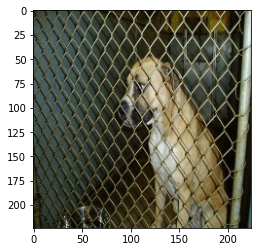

In [7]:
data = cats_dogs(train_data_dir)
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu()) #permute for matplotlib, it expects the channels last, after width and height info
print(label)

Now we define the model and the loss function as well as the optimizer.

We will first define the conv_layer function, where we perform the convolution, ReLU activation, batch normalization and max pooling.

In [8]:
def conv_layer(ni, no, kernel_size, stride = 1):
  # ni - number of input channels
  # no - number of output channels
  # kernel_size and stride are self explanatory 
  return nn.Sequential(
      nn.Conv2d(ni,no,kernel_size,stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

We will now define the get_model function, which performs multiple convolutions and pooling operations, flattens the output and connects it to a hidden layer and then an output layer

In [9]:
def get_model():
  model = nn.Sequential(
      conv_layer(3,64,3),
      conv_layer(64,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      nn.Flatten(),
      nn.Linear(512,1),
      nn.Sigmoid()
  ).to(device)
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
  return model, loss_fn, optimizer

Let's get and summarize the model

In [10]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

We will now create a get_data function, which creates a DataLoader with an cats_dogs object and with a batch_size of 32, for both validation and training folders

In [11]:
def get_data():
  train = cats_dogs(train_data_dir)
  trn_dl = DataLoader(train, batch_size = 32, shuffle = True, drop_last = True)
  val = cats_dogs(test_data_dir)
  val_dl = DataLoader(val, batch_size = 32, shuffle = True, drop_last = True) #drop_last just discards the last batch of data if it's not the same size as the others i.e. if it's smaller

  return trn_dl, val_dl

Let's define a function for training

In [12]:
def train_batch(x,y,model,optimizer,loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

Define the functions for the accuracy of the model as well as the validation loss function

In [13]:
@torch.no_grad()
def accuracy(x,y,model):
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x,y,model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

We will now train the model for 5 epochs

In [14]:
trn_dl, val_dl = get_data() #get dataloaders for train and val datasets
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss) #we keep the losses per epoch per batch in this list
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x,y,model)
    train_epoch_accuracies.extend(is_correct) #we keep track of the accuracy of the model per batch per epoch
  train_epoch_accuracy = np.mean(train_epoch_accuracies) #accuracy of the model in the given epoch

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x,y,model)
    val_epoch_accuracies.extend(val_is_correct) #we keep track whether or not the model is correct for this batch of the val dataset in this epoch
  val_epoch_accuracy = np.mean(val_epoch_accuracies) #the accuracy of the model on the val dataset in this epoch

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)
  

Let's check the accuracy of our model

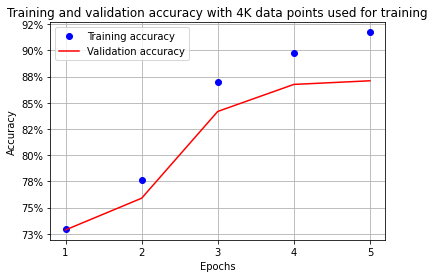

In [15]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', 
 label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', 
 label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
 for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()


We can see that our model has achieved an accuracy of 88% which is sufficiently good for the purposes of relatively accurate predictions.